# 07. Машинное обучение в бизнесе

# Выбор локации для скважины

В рамках исследования, мы предполагаем, что работаем в добывающей компании «ГлавРосГосНефть». Нам необходимо решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель:** Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски требуется техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-моделей" data-toc-modified-id="Обучение-и-проверка-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка моделей</a></span><ul class="toc-item"><li><span><a href="#Обучение-и-проверка-модели-для-региона-№1" data-toc-modified-id="Обучение-и-проверка-модели-для-региона-№1-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение и проверка модели для региона №1</a></span></li><li><span><a href="#Обучение-и-проверка-модели-для-региона-№2" data-toc-modified-id="Обучение-и-проверка-модели-для-региона-№2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение и проверка модели для региона №2</a></span></li><li><span><a href="#Обучение-и-проверка-модели-для-региона-№3" data-toc-modified-id="Обучение-и-проверка-модели-для-региона-№3-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение и проверка модели для региона №3</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import warnings

In [2]:
warnings.filterwarnings('ignore')
state = np.random.RandomState(12345)

## Загрузка и подготовка данных

Загрузим данные геологоразведки трех регионов.

In [3]:
df1 = pd.read_csv('geo_data_0.csv')
df2 = pd.read_csv('geo_data_1.csv')
df3 = pd.read_csv('geo_data_2.csv')

In [4]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


**Признаки:**

- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — характеристики скважин

**Целевой признак:**

- `product` — объём запасов в скважине (тыс. баррелей)

Теперь посмотрим на общую информацию о таблице.

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Видим, что пропущенных значений нет. Типы значений признаков корректны, преобразование не требуется.

Далее посмотрим на информацию о втором и третьем регионе.

In [6]:
# второй регион
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
# третий регион
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Вывод**

Загрузили данные о нефтяных скважинах трех регионов. Определили, что пропусков в данных нет, типы значений признаков не требуют преобразования. Данные готовы к построению моделей.

## Обучение и проверка моделей

Разделим исходные данные на обучающую и валидационную выборки в соотношении 75%:25%. Для этого, сначала отделим целевой признак (`product`) от остальных. Признак, содержащий уникальный идентификатор скважины (`id`), избыточен для обучаемой модели, поэтому уберем его из нашего исследования. Данные действия производим для всех трех регионов.

### Обучение и проверка модели для региона №1

Выделяем целевой признак для первого региона.

In [10]:
target1 = df1['product']
features1 = df1.drop(['id','product'] , axis=1)

Делим данные первого региона на тренировочную и валидационную выборки.

In [11]:
features1_train, features1_valid, target1_train, target1_valid = train_test_split(features1, 
                                                                              target1, 
                                                                              test_size=0.25, 
                                                                              random_state=state)

Обучаем модель и предсказываем значения запасов сырья в скважине.

In [12]:
model1 = LinearRegression()
model1.fit(features1_train, target1_train)
predicted1_valid = model1.predict(features1_valid)

Найдем средний запас предсказанного сырья и оценим качество модели (метрики RMSE, MAE и R2) для региона №1. Посмотрим на распределение запасов нефти в скважинах (на валидационной выборке). Для этого напишем функцию **'print_info'**.

In [13]:
def print_info(target, predicted, num_reg):
    print('Средний запас сырья в регионе №1 (реальный):', target.mean())
    print(f'Средний запас предсказанного сырья в регионе №{num_reg}:', predicted.mean())
    mse = mean_squared_error(target, predicted)
    r2 = r2_score(target, predicted)
    mae = mean_absolute_error(target, predicted)
    print('RMSE модели:', mse**0.5)
    print('MAE:', mae)
    print('R2-score:', r2)
    plt.figure(figsize=(16, 5))
    plt.grid()
    plt.hist([pd.Series(predicted), pd.Series(target)], bins=20, label=['Предсказанные значения', 'Реальные значения'])
    plt.xlabel('Объем запасов нефти в скважине (тыс. баррелей)')
    plt.ylabel('Количество объектов')
    plt.title(f'Распределение объемов запасов нефти в скважинах региона №{num_reg}')
    plt.legend(loc='upper right')
    plt.show()

Средний запас сырья в регионе №1 (реальный): 92.07859674082927
Средний запас предсказанного сырья в регионе №1: 92.59256778438035
RMSE модели: 37.5794217150813
MAE: 30.919600777151313
R2-score: 0.27994321524487786


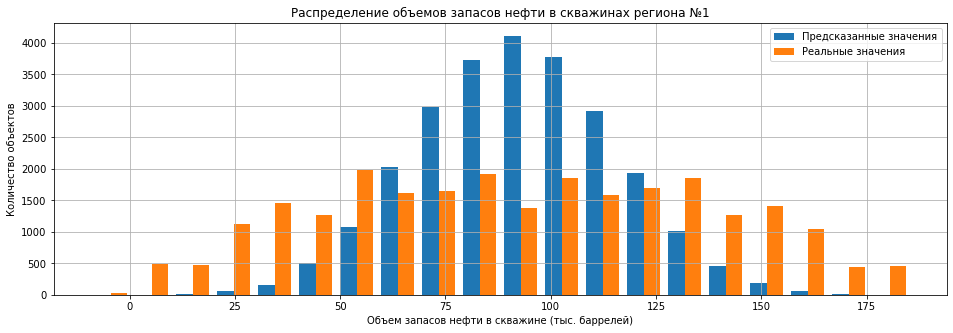

In [14]:
print_info(target1_valid, predicted1_valid, 1)

**Вывод**

Средние запасы нефти по всем скважинам региона модель предсказывает корректно (~92.5). Тем не менее, модель получилась не высокого качества, что подтверждается метрикой **R2-score = 0.28**, и высокими значениями средних ошибок: **RMSE = 37.58** и **MAE = 30.92**. Такие величины ошибок (разброс предсказанных значений от реальных) могут быть связаны с: 
- ошибочными данными (признаками объектов) в датафрейме;
- недостаточным количеством признаков объектов в датафрейме, из-за чего, модель плохо отрабатывает на малых (< 50) и больших (> 125) значениях;
- необходимостью применения другой модели машинного обучения.

### Обучение и проверка модели для региона №2

In [15]:
# выделяем целевой признак для второго региона
target2 = df2['product']
features2 = df2.drop(['id','product'] , axis=1)

In [16]:
# делим данные второго региона на тренировочную и валидационную выборки
features2_train, features2_valid, target2_train, target2_valid = train_test_split(features2, 
                                                                              target2, 
                                                                              test_size=0.25, 
                                                                              random_state=state)

In [17]:
# обучаем модель и предсказываем значения запасов сырья в скважине
model2 = LinearRegression()
model2.fit(features2_train, target2_train)
predicted2_valid = model2.predict(features2_valid)

Найдем средний запас предсказанного сырья и оценим качество модели (метрики RMSE, MAE и R2) для региона №2. Посмотрим на распределение запасов нефти в скважинах (на валидационной выборке). 

Средний запас сырья в регионе №1 (реальный): 68.77162424984647
Средний запас предсказанного сырья в регионе №2: 68.76995145799754
RMSE модели: 0.8897367737680649
MAE: 0.7172924802490798
R2-score: 0.9996264922748638


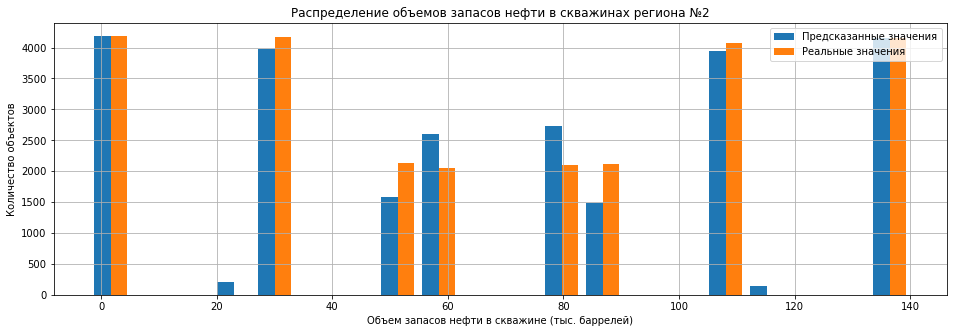

In [18]:
print_info(target2_valid, predicted2_valid, 2)

**Вывод**

Средние запасы нефти по всем скважинам региона №2 модель также предсказывает корректно (~68.8). В отличие от модели, построенной для региона №1, модель для региона №2 получилась высокого качества, что подтверждается метрикой **R2-score = 0.999**, и низкими значениями средних ошибок: **RMSE = 0.89** и **MAE = 0.72**. 

Столь низкие значения ошибок заставляют задуматься о корректности данных, с этим вопросом требуется обратиться к коллегам, предоставившим выборку для разъяснений.

### Обучение и проверка модели для региона №3

In [19]:
# выделяем целевой признак для третьего региона
target3 = df3['product']
features3 = df3.drop(['id','product'] , axis=1)

In [20]:
# делим данные третьего региона на тренировочную и валидационную выборки
features3_train, features3_valid, target3_train, target3_valid = train_test_split(features3, 
                                                                              target3, 
                                                                              test_size=0.25, 
                                                                              random_state=state)

In [21]:
model3 = LinearRegression()
model3.fit(features3_train, target3_train)
predicted3_valid = model3.predict(features3_valid)

Найдем средний запас предсказанного сырья и оценим качество модели (метрики RMSE, MAE и R2) для региона №3. Посмотрим на распределение запасов нефти в скважинах (на валидационной выборке). 

Средний запас сырья в регионе №1 (реальный): 94.74895871720241
Средний запас предсказанного сырья в регионе №3: 95.087528122523
RMSE модели: 39.958042459521614
MAE: 32.796102875544854
R2-score: 0.20261508041163934


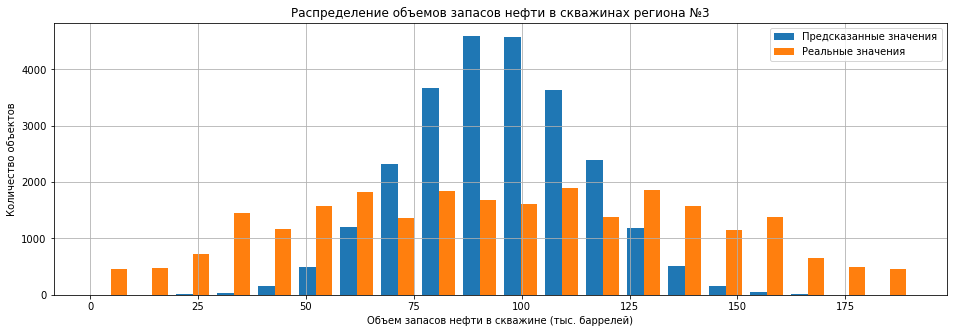

In [22]:
print_info(target3_valid, predicted3_valid, 3)

**Вывод**

Средние запасы нефти по всем скважинам региона модель предсказывает корректно (~95). Тем не менее, модель получилась не высокого качества, что подтверждается метрикой **R2-score = 0.2**, и высокими значениями средних ошибок: **RMSE = 39.96** и **MAE = 32.8**. Причины таких величин ошибок (разброс предсказанных значений от реальных) такие же, как и для региона №1. Модель плохо отрабатывает на малых (< 60) и больших (> 125) значениях.

## Подготовка к расчёту прибыли

По условию известно, что общий бюджет на разработку скважин в регионе (`TOTAL_BUDGET`) составляет 10 млрд. рублей. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки (`NUM_OILWELL`).

In [23]:
TOTAL_BUDGET = 10000000000
NUM_OILWELL = 200

Рассчитаем бюджет на разработку одной скважины `budget_per_one_oilwell`:

In [24]:
budget_per_one_oilwell = TOTAL_BUDGET / NUM_OILWELL
budget_per_one_oilwell

50000000.0

Получили, что **бюджет для разработки одной скважины составляет 50 млн. рублей**. Также нам известно, что доход с каждой единицы продукта составляет 450 тыс. рублей (`REVENUE_PER_UNIT`). Следовательно, мы можем рассчитать достаточный объём сырья для безубыточной разработки новой скважины (`min_amount_oil`).

In [25]:
REVENUE_PER_UNIT = 450000
min_amount_oil = budget_per_one_oilwell / REVENUE_PER_UNIT
min_amount_oil

111.11111111111111

Выяснили, что для того, чтобы вложения в разработку скважины окупились, в ней должно содержаться **не менее 111.11 тысяч баррелей нефти**.

**Вывод**

Во всех трех рассматриваемых регионах присутствует большое количество скважин с объемом сырья в них более 111 тыс. баррелей. Однако, посмотрев на обученные модели для регионов №1 и №3, мы определили, что они дают предсказания целевого признака с значительными ошибками для больших значений (> 125 тыс. баррелей). По этой причине, можем предположить, что для этих регионов риски убыточных вложений инвестиций будут значительно выше, чем для региона №2.

## Расчёт прибыли и рисков 

Рассчитаем прибыль от вложения инвестиций в разработку нефтяных скважин для трех регионов. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели (**'revenue'**). Данная функция:
- выберает скважины с наибольшими значениями предсказаний;
- суммирует целевое значение объёма сырья, соответствующее этим предсказаниям;
- наконец, рассчитывает прибыль для полученного объёма сырья.

In [26]:
def revenue(target, predict, count):
    probs_sorted = predict.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return REVENUE_PER_UNIT * selected.sum()

Функция **'oil_production'** необходима для:
- расчета возможной средней прибыли от разработки 200 лучших (по предсказанным показателям целевого признака) нефтяных скважин;
- нахождения 95%-го доверительного интервала для возможной средней прибыли;
- расчета риска убыточных вложений в разработку нефтяных скважин региона.

In [27]:
def oil_production(model, target, features):
    values = []
    predict = pd.Series(model.predict(features))
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state=state)
        predict_subsample = predict[target_subsample.index]
        values.append(revenue(target_subsample, predict_subsample, 200))

    values = pd.Series(values)

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()

    distr = st.norm(mean, np.std(values, ddof=1))
    risk = distr.cdf(TOTAL_BUDGET)

    print(f'Средняя прибыль:', round(((mean - TOTAL_BUDGET) / 1000000), 3), 'млн. руб.')
    print(f'95%-й доверительный интервал: ({round((lower - TOTAL_BUDGET) / 1000000, 3)},', 
          f'{round((upper - TOTAL_BUDGET) / 1000000, 3)}) млн. руб.')
    print('Риск убытков: {:.2%}'.format(risk))

Рассчитаем вероятную среднюю прибыль, 95%-й доверительный интервал вероятной средней прибыли, а также риски убытков для трех регионов.

In [28]:
print('-----------------------Регион №1-----------------------\n')
oil_production(model1, target1, features1)
print()
print('-----------------------Регион №2-----------------------\n')
oil_production(model2, target2, features2)
print()
print('-----------------------Регион №3-----------------------\n')
oil_production(model3, target3, features3)

-----------------------Регион №1-----------------------

Средняя прибыль: 421.475 млн. руб.
95%-й доверительный интервал: (-104.64, 941.102) млн. руб.
Риск убытков: 5.87%

-----------------------Регион №2-----------------------

Средняя прибыль: 458.131 млн. руб.
95%-й доверительный интервал: (75.875, 871.875) млн. руб.
Риск убытков: 1.19%

-----------------------Регион №3-----------------------

Средняя прибыль: 377.597 млн. руб.
95%-й доверительный интервал: (-163.311, 895.056) млн. руб.
Риск убытков: 8.13%


**Вывод**

В результате расчетов имеем следующее:

1. Средняя прибыль в регионах составляет: 
    - 428 млн. рублей - для региона №1, 
    - 465 млн. рублей - для региона №2,
    - 379 млн. рублей - для региона №3.

2. Принимая во внимание заданное по условию значения порога риска убытка (не более 2.5%), следовало бы предложить регион №2 для разработки нефтяных скважин, т.к. риск убытков составляет ~1.5%, однако не стоит брать данный регион в рассчет - результаты слишком хорошие. Необходимо уточнить причины формы распределения целевого признака и построить модель еще раз. 
3. Для моделей, построенных по данным о регионах 1 и 3, стоит уточнить признаки и их корректность, и, возможно, улучшить прогнозы.